# 说明

1.数据集来源为kaggle，因为是一个demo，且需要验证结果，所以仅取其训练集；
2.本项目主要为了说明构建一张简单的评分卡（A卡，也就是贷前）的过程，所以省略了EDA的部分，仅仅做一个简单的流程说明。
3.与之前的逻辑回归评分卡不同，本次主要尝试用xgboost做一张评分卡


# 导入相关包

In [61]:
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import math
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve
import warnings
import plotly.express as px
import sklearn.metrics as metrics
import xgboost as xgb

warnings.filterwarnings('ignore')
plt.rcParams['font.family']='Microsoft YaHei' #显示中文标签
plt.style.use ('ggplot') #设定绘图风格
import seaborn as sns

pd.set_option('max_columns',1000)
pd.set_option('max_row',300)
pd.set_option('display.float_format', lambda x:' %.5f' % x)

# 数据集

## 导入数据

In [56]:
df_data = pd.read_csv(r'C:\Users\hp\Desktop\cs-training.csv',encoding='GB18030',index_col=0)
df_data.shape

(150000, 11)

## 查看数据集

In [57]:
df_data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.76613,45,2,0.80298,9120.00000,13,0,6,0,2.00000
2,0,0.95715,40,0,0.12188,2600.00000,4,0,0,0,1.00000
3,0,0.65818,38,1,0.08511,3042.00000,2,1,0,0,0.00000
4,0,0.23381,30,0,0.03605,3300.00000,5,0,0,0,0.00000
5,0,0.90724,49,1,0.02493,63588.00000,7,0,1,0,0.00000


# 缺失值处理

## 查看数据缺失值

In [58]:
null_val_sums = df_data.isnull().sum()
pd.DataFrame({"特征名称": null_val_sums.index, "缺失值数目": null_val_sums.values,
             "缺失值占比": null_val_sums.values / len(df_data) })

,特征名称,缺失值数目,缺失值占比
0,SeriousDlqin2yrs,0,0.00000
1,RevolvingUtilizationOfUnsecuredLines,0,0.00000
2,age,0,0.00000
3,NumberOfTime30-59DaysPastDueNotWorse,0,0.00000
4,DebtRatio,0,0.00000
5,MonthlyIncome,29731,0.19821
6,NumberOfOpenCreditLinesAndLoans,0,0.00000
7,NumberOfTimes90DaysLate,0,0.00000
8,NumberRealEstateLoansOrLines,0,0.00000
9,NumberOfTime60-89DaysPastDueNotWorse,0,0.00000


## 缺失值填补

填补方法很多，比如给一个极端值-9999，或者分箱单独分为一箱，平均值填充，中位数填充等等，此处我们用中位数做简单填补

In [59]:
for i in null_val_sums.index:
    df_data[i] = df_data[i].fillna(df_data[i].median())

In [60]:
null_val_sums = df_data.isnull().sum()
pd.DataFrame({"特征名称": null_val_sums.index, "缺失值数目": null_val_sums.values,
             "缺失值占比": null_val_sums.values / len(df_data) })

,特征名称,缺失值数目,缺失值占比
0,SeriousDlqin2yrs,0,0.00000
1,RevolvingUtilizationOfUnsecuredLines,0,0.00000
2,age,0,0.00000
3,NumberOfTime30-59DaysPastDueNotWorse,0,0.00000
4,DebtRatio,0,0.00000
5,MonthlyIncome,0,0.00000
6,NumberOfOpenCreditLinesAndLoans,0,0.00000
7,NumberOfTimes90DaysLate,0,0.00000
8,NumberRealEstateLoansOrLines,0,0.00000
9,NumberOfTime60-89DaysPastDueNotWorse,0,0.00000


# 模型建立

## 数据集切分

In [63]:
feature_list = list(df_data)
del feature_list[0]
feature_list

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate',
 'NumberRealEstateLoansOrLines',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfDependents']

In [96]:
X_train_T, X_test, y_train_T, y_test = train_test_split(df_data[feature_list], df_data['SeriousDlqin2yrs'], test_size=0.2, random_state=42,stratify=df_data['SeriousDlqin2yrs'])
X_train, X_valid, y_train, y_valid = train_test_split(X_train_T[feature_list], y_train_T, test_size=0.2, random_state=42,stratify=y_train_T)

print('坏样本占比为： ',y_train.mean())

坏样本占比为：  0.06684375


## 建立Xgboost模型

In [71]:
eval_set = [(X_valid, y_valid)]
model_xgb = xgb.XGBClassifier(random_state=2022,n_estimators=800).fit(X_train,y_train,early_stopping_rounds=100, eval_metric="auc",eval_set=eval_set)



[0]	validation_0-auc:0.84390
[1]	validation_0-auc:0.84827
[2]	validation_0-auc:0.85160
[3]	validation_0-auc:0.85200
[4]	validation_0-auc:0.85278
[5]	validation_0-auc:0.85278
[6]	validation_0-auc:0.85396
[7]	validation_0-auc:0.85675
[8]	validation_0-auc:0.85794
[9]	validation_0-auc:0.85864
[10]	validation_0-auc:0.85888
[11]	validation_0-auc:0.85955
[12]	validation_0-auc:0.85928
[13]	validation_0-auc:0.86036
[14]	validation_0-auc:0.85988
[15]	validation_0-auc:0.86011
[16]	validation_0-auc:0.86057
[17]	validation_0-auc:0.86058
[18]	validation_0-auc:0.86068
[19]	validation_0-auc:0.86095
[20]	validation_0-auc:0.86094
[21]	validation_0-auc:0.86071
[22]	validation_0-auc:0.86071
[23]	validation_0-auc:0.86069
[24]	validation_0-auc:0.86082
[25]	validation_0-auc:0.86091
[26]	validation_0-auc:0.86098
[27]	validation_0-auc:0.86059
[28]	validation_0-auc:0.86072
[29]	validation_0-auc:0.86073
[30]	validation_0-auc:0.86081
[31]	validation_0-auc:0.86050
[32]	validation_0-auc:0.86048
[33]	validation_0-au

## 模型评价标准

1.AUC：AUC为ROC曲线的面积，取值为[0，1]，越接近1证明模型预测效果越好。ROC曲线的纵坐标轴为TPR；横坐标轴为FPR。一般AUC>0.8证明效果还可以，可以考虑上线。
2.KS值：衡量的是好坏样本累计分布之间的差值。好坏样本累计差异越大，KS指标越大，那么模型的风险区分能力越强，当KS值>0.4，且训练集和测试集相差不超过5%，正负样本区分度还不错。

train_ks: 0.6170186473625132
evl_ks: 0.5775063145850323


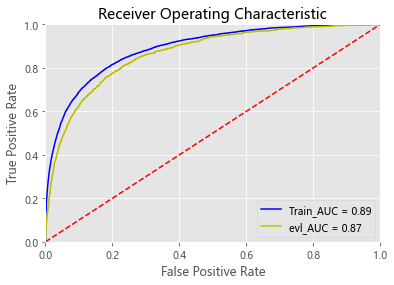

In [76]:
y_pred_train = model_xgb.predict_proba(X_train)[:,1]
fpr_xgb_train,tpr_xgb_train,_=metrics.roc_curve(y_train,y_pred_train)
train_ks = abs(fpr_xgb_train-tpr_xgb_train).max()
roc_auc_train = metrics.auc(fpr_xgb_train, tpr_xgb_train)
print('train_ks:',train_ks)

y_pred = model_xgb.predict_proba(X_test)[:,1]
fpr_xgb_evl,tpr_xgb_evl,_=metrics.roc_curve(y_test,y_pred)
evl_ks = abs(fpr_xgb_evl-tpr_xgb_evl).max()
roc_auc_evl = metrics.auc(fpr_xgb_evl, tpr_xgb_evl)
print('evl_ks:',evl_ks)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr_xgb_train, tpr_xgb_train, 'b', label = 'Train_AUC = %0.2f' % roc_auc_train)
plt.plot(fpr_xgb_evl, tpr_xgb_evl, 'y', label = 'evl_AUC = %0.2f' % roc_auc_evl)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# 基于Logistic回归的评分卡转换

#### 评分卡转换原理

​		客户违约概率为p，正常概率为1-p，违约概率与正常概率的比值，称为Odds，即：
$$
Odds=\frac{p}{1-p}    ----(1)
$$

逻辑回归公式为：
$$
p=\frac{1}{1+e^-\theta^Tx} ----   (2)
$$
同时取ln
$$
ln(\frac{p}{1-p})=\theta^Tx  ---- (3) 
$$
将公式（1）代入（3）,即：
$$
ln(Odds)=\theta^Tx   ----(4)
$$
评分卡的背后逻辑是Odds的变动与评分变动的映射（把Odds映射为评分），即通过下述公式进行映射：
$$
Score=A-B*ln（Odds）----（5）
$$
其中A与B是常数，B前面取负号的原因，是让违约概率越低，得分越高。因为实际业务里，分数也高风险越低，风控里默认高分高信用低风险
计算出A、B的方法如下：
1. 设定基准分。基准分为$A-B*\theta_0$，也就是$p_0$，当odds无变动时，$\theta_0$=1，A=$p_0$,此处我们设定基础分为650；
2. PDO（point of double），比率翻番时分数的变动值。此处设置为当odds翻倍时，分值减少50。
由上述可得：
$$
P_0=A-B*ln(\theta_0)
$$
根据PDO的定义，有下面等式：
$$
P_0-PDO=A-B*ln(2\theta_0)
$$
上述两个等式联立求解

可得：
$$
B=\frac{PDO}{ln2}\\
A=P_0+B*ln(\theta_0)
$$
评分卡里每一个变量x的每一个分箱有一个对应分值，即将每个特征的重要性权值与特征分箱的WOE编码进行结合计算，其计算方法如下：

$$
Score=A-B\{\theta_i\omega_{ij}\}
$$
其中，$\theta_i$表示第i个特征的重要性得分,$\omega_{ij}$表示第i个特征的第j个分箱的WOE编码的分数。

# 基于Xgboost的评分卡转换

上述逻辑回归评分卡还有第二种得分映射方式，这种方式不考虑评分转换的真正含义，之间使用预测的概率去进行映射，使用换底公式，
$$
Score=A-B*ln（Odds）=A-B*log_{2}(Odds)*ln(2)
$$
当PDO取50时，上述公式又可以换成：
$$
Score=A-50*log_{2}(Odds)
$$
按照同样的逻辑，只要找出给出xgboost的odds，即负样本概率与正样本概率的比率，就可以做得分映射。即有：
$$
Score=A-50*log_{2}(\frac{1-p}{p})
$$
其中，p为xgboost预测的概率。
当然，这样就没办法得到每个特征的具体得分

In [1]:
def score(p):
    score = 650+50*(math.log2((1-p)/p))
    return score

# 给建卡数据、验证数据打分

 ## 对建卡数据进行得分映射

In [85]:
train_score = []
for i in range(len(y_pred_train)):
    s = score(list(y_pred_train)[i])
    train_score.append(s)

In [98]:
dfs = pd.DataFrame(columns = ["标签", "总分"])
dfs['标签'] = list(y_train)
dfs['总分'] = train_score
dfs

,标签,总分
0,0,835.02480
1,0,684.41649
2,0,1002.79850
3,0,905.57798
4,0,934.31384
...,...,...
95995,0,878.62418
95996,0,875.20583
95997,0,927.19486
95998,0,922.15988


In [101]:
print ('好样本得分区间',dfs[dfs['标签'] == 0][['总分']].min(),dfs[dfs['标签'] == 0][['总分']].max()) 
print ('坏样本得分区间',dfs[dfs['标签'] == 1][['总分']].min(),dfs[dfs['标签'] == 1][['总分']].max()) 

好样本得分区间 总分    492.76539
dtype: float64 总分    1090.30022
dtype: float64
坏样本得分区间 总分    413.03903
dtype: float64 总分    1074.73830
dtype: float64


## 对验证数据进行得分映射

In [102]:
evl_score = []
for i in range(len(y_pred)):
    s = score(list(y_pred)[i])
    evl_score.append(s)

In [103]:
dfs2 = pd.DataFrame(columns = ["标签", "总分"])
dfs2['标签'] = list(y_test)
dfs2['总分'] = evl_score
dfs2


,标签,总分
0,0,1009.23529
1,0,896.70093
2,0,1014.05260
3,0,984.56542
4,0,969.93286
...,...,...
29995,0,1043.68098
29996,0,854.25425
29997,0,969.26701
29998,0,1044.62231


In [104]:
print ('好样本得分区间',dfs2[dfs2['标签'] == 0][['总分']].min(),dfs2[dfs2['标签'] == 0][['总分']].max()) 
print ('坏样本得分区间',dfs2[dfs2['标签'] == 1][['总分']].min(),dfs2[dfs2['标签'] == 1][['总分']].max()) 

好样本得分区间 总分    488.54652
dtype: float64 总分    1090.30022
dtype: float64
坏样本得分区间 总分    460.06514
dtype: float64 总分    1071.96614
dtype: float64


# 评估

## 首先查看建卡数据的得分分布

比较好的分布图肯定是两个单峰，且好用户和坏用户交叉不多，目前这个由于上述各种偷懒操作且特征本身也不多，效果并不理想，但是可以继续向下走流程。

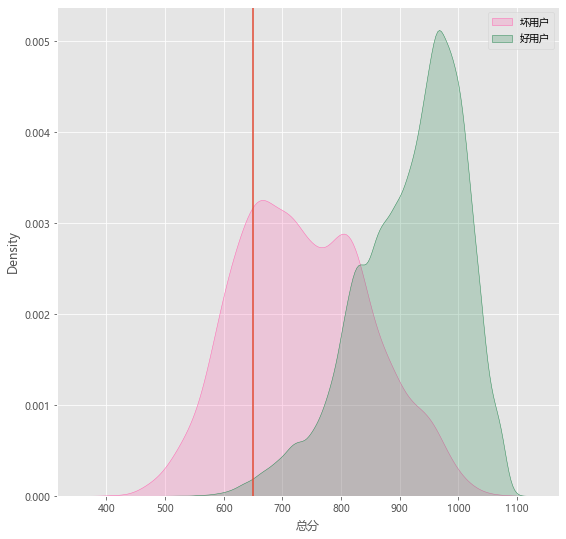

In [106]:
# 得分分布图
def plot_score_hist(df,target,score_col,plt_size=None,cutoff=None):
    """
    df:数据集
    target:目标变量的字段名
    score_col:最终得分的字段名
    plt_size:图纸尺寸
    cutoff :划分拒绝/通过的点
    
    return :好坏用户的得分分布图
    """    
    plt.figure(figsize=plt_size)
    x1 = df[df[target]==1][score_col]
    x2 = df[df[target]==0][score_col]
    sns.kdeplot(x1,shade=True,label='坏用户',color='hotpink')
    sns.kdeplot(x2,shade=True,label='好用户',color ='seagreen')
    plt.axvline(x=cutoff)
    plt.legend()
    return plt.show()
plot_score_hist(dfs,'标签','总分',plt_size=(9,9),cutoff=650)

## 搜索CUTOFF

对于评分卡来说，需要有一条线或者说是一个得分点来对数据进行切分此出先将其称为Cutoff，高于这条线，接受，低于则拒绝
下面通过寻找KS值最大的点进行一个粗筛，实际业务还会根据通过率、坏样本累计占比等因素进行调整。

In [108]:
def search_cutoff(df,col_score,target):
    
    cutoff = list(range(600, 1000))
    refuse_acc=[]
    tpr_ls=[]
    fpr_ls=[]
    KS_ls=[]
    for i in cutoff:
        df['result'] = df.apply(lambda x:'拒绝' if x[col_score]<=i else '接受',axis=1)
        TP = df[(df['result']=='拒绝')&(df[target]==1)].shape[0] 
        FN = df[(df['result']=='拒绝')&(df[target]==0)].shape[0] 
        bad = df[df[target]==1].shape[0] 
        good = df[df[target]==0].shape[0] 
        refuse = df[df['result']=='拒绝'].shape[0] 
        passed = df[df['result']==10].shape[0] 
        tpr = round(TP/bad,3) 
        fpr = round(FN/good,3) 
        KS = abs(tpr-fpr)
        KS_ls.append(KS)
        
    maxid_KS = KS_ls.index(max(KS_ls))
    co4 = cutoff[maxid_KS]
    print('最大KS值:{}'.format(max(KS_ls)))
    print('KS最大的分数:{}'.format(co4))                     

    return 

search_cutoff(dfs,'总分','标签')

最大KS值:0.6160000000000001
KS最大的分数:830


In [110]:
# 设定cutoff点，衡量有效性
def rule_verify(df,col_score,target,cutoff):
    """
    df:数据集
    target:目标变量的字段名
    col_score:最终得分的字段名    
    cutoff :划分拒绝/通过的点
    
    return :混淆矩阵
    """
    df['result'] = df.apply(lambda x:'拒绝' if x[col_score]<=cutoff else '接受',axis=1)
    TP = df[(df['result']=='拒绝')&(df[target]==1)].shape[0] 
    FN = df[(df['result']=='拒绝')&(df[target]==0)].shape[0] 
    bad = df[df[target]==1].shape[0] 
    good = df[df[target]==0].shape[0] 
    refuse = df[df['result']=='拒绝'].shape[0] 
    passed = df[df['result']==10].shape[0] 
     
    acc = round(TP/refuse,3) 
    tpr = round(TP/bad,3) 
    fpr = round(FN/good,3) 
    pass_rate = round(refuse/df.shape[0],3) 
    matrix_df = pd.pivot_table(df,index='result',columns=target,aggfunc={col_score:pd.Series.count},values=col_score) 
    
    print('拒绝准确率:{}'.format(acc))
    print('查全率:{}'.format(tpr))
    print('误伤率:{}'.format(fpr))
    print('规则拒绝率:{}'.format(pass_rate))
    return matrix_df

rule_verify(dfs,'总分','标签',830)

拒绝准确率:0.245
查全率:0.79
误伤率:0.174
规则拒绝率:0.215


标签,0,1
result,,
拒绝,15611.00000,5071.00000
接受,73972.00000,1346.00000


可以看出，这张卡要比之前的逻辑回归评分卡效果好不少，查全率提升的同事，误伤率也低了许多

## 再看下在验证数据上的结果

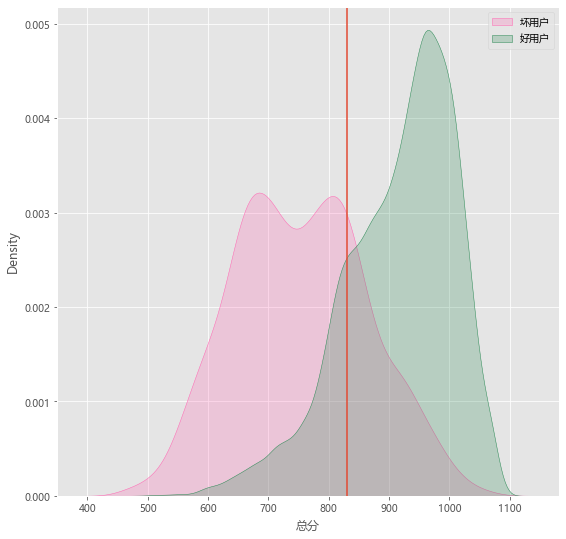

In [111]:
plot_score_hist(dfs2,'标签','总分',plt_size=(9,9),cutoff=830)

可以看出，cutoff能够区分大部分样本

In [112]:
rule_verify(dfs2,'总分','标签',830)

拒绝准确率:0.232
查全率:0.752
误伤率:0.178
规则拒绝率:0.216


标签,0,1
result,,
拒绝,4983.00000,1507.00000
接受,23012.00000,498.00000


可以看出，这张评分卡有78.4%的通过率，误伤率也相对之前的卡更低，查全率更高，总体要优于于之前的逻辑回归评分卡，当然逻辑回归评分卡并非最优结果，还有提升和改进的空间，而且逻辑回归评分卡解释性也相对更强一些，更便于理解。
这张卡做到这里就结束了，个人也属于相关初学者，如有错误疏漏，欢迎指出，一起学习探讨